<center>
<a href="http://www.insa-toulouse.fr/" ><img src="http://www.math.univ-toulouse.fr/~besse/Wikistat/Images/logo-insa.jpg" style="float:left; max-width: 120px; display: inline" alt="INSA"/></a> 
</center>

## Objectifs : 
<span style="color:  rgb(139, 0, 0)">**Notre projet consiste à analyser et faire des prédictions sur un jeu de données qui fournit un aperçu détaillé des routines d’exercice, des attributs physiques et des mesures de la condition physique des membres d’une salle de sport. Il y a deux objectifs principales pour ce projet :  Le premier objectif est de faire une analyse exploratoire des données pour bien cerner nos données. Dans un second temps, on effectuera deux modélisations avec la prédiction de calories brulées et du niveau d'expérience.**</span>

## Table des matières
1. [Analyse explorative des données (langage R)](#analyse-données)
   - Description général (natures des variables, encodages ...)
   - Analyse descriptive unidimensionnelle et bidimensionnelle
   - ACP des différentes variables
2. [Modélisation (langage R et python)](#modélisation)
   - Prédiction des calories brulées
   - Prédiction du niveau d'expérience
## Analyse explorative des donées (langage R)
Cette partie se fera uniquement en R. 

In [2]:
# Chargement des librairies nécessaires
library(ggplot2)
library(tidyverse)
library(gridExtra)
library(GGally)
library(plotly)
library(corrplot)
library(reshape2)
library(FactoMineR) 
library(factoextra)
library(glmnet) 
library(ggfortify)
library(pROC)
library(ROCR)

Warning message:
"le package 'tidyverse' a été compilé avec la version R 4.4.2"
Warning message:
"le package 'readr' a été compilé avec la version R 4.4.2"
Warning message:
"le package 'lubridate' a été compilé avec la version R 4.4.2"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"le package 'gridExtra' a été compilé avec la version R 4.4.2"

Attachement du package : 'gridExtra'


L'objet suivant est masqué depuis 'package:dplyr':

    combine

ERROR: Error in library(plotly): aucun package nommé 'plotly' n'est trouvé


In [8]:
# Lecture des données
# path="http://www.math.univ-toulouse.fr/~besse/Wikistat/data/"
path <- ""
data <- read.table(paste(path, "gym_members_exercise_tracking.csv", sep = ""),
                    sep = ",", header = TRUE)
# Premières lignes du jeu de données
head(data)
# Vérification du contenu
summary(data)

,Age,Gender,Weight..kg.,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Calories_Burned,Workout_Type,Fat_Percentage,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,BMI
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,56,Male,88.3,1.71,180,157,60,1.69,1313,Yoga,12.6,3.5,4,3,30.20
2,46,Female,74.9,1.53,179,151,66,1.30,883,HIIT,33.9,2.1,4,2,32.00
3,32,Female,68.1,1.66,167,122,54,1.11,677,Cardio,33.4,2.3,4,2,24.71
4,25,Male,53.2,1.70,190,164,56,0.59,532,Strength,28.8,2.1,3,1,18.41
5,38,Male,46.1,1.79,188,158,68,0.64,556,Strength,29.2,2.8,3,1,14.39
6,56,Female,58.0,1.68,168,156,74,1.59,1116,HIIT,15.5,2.7,5,3,20.55


      Age           Gender           Weight..kg.       Height..m.   
 Min.   :18.00   Length:973         Min.   : 40.00   Min.   :1.500  
 1st Qu.:28.00   Class :character   1st Qu.: 58.10   1st Qu.:1.620  
 Median :40.00   Mode  :character   Median : 70.00   Median :1.710  
 Mean   :38.68                      Mean   : 73.85   Mean   :1.723  
 3rd Qu.:49.00                      3rd Qu.: 86.00   3rd Qu.:1.800  
 Max.   :59.00                      Max.   :129.90   Max.   :2.000  
    Max_BPM         Avg_BPM       Resting_BPM    Session_Duration..hours.
 Min.   :160.0   Min.   :120.0   Min.   :50.00   Min.   :0.500           
 1st Qu.:170.0   1st Qu.:131.0   1st Qu.:56.00   1st Qu.:1.040           
 Median :180.0   Median :143.0   Median :62.00   Median :1.260           
 Mean   :179.9   Mean   :143.8   Mean   :62.22   Mean   :1.256           
 3rd Qu.:190.0   3rd Qu.:156.0   3rd Qu.:68.00   3rd Qu.:1.460           
 Max.   :199.0   Max.   :169.0   Max.   :74.00   Max.   :2.000           

In [9]:
data[, "Gender"] <- as.factor(data[, "Gender"])
data[, "Workout_Type"] <- as.factor(data[, "Workout_Type"])
data[, "Experience_Level"] <- as.factor(data[, "Experience_Level"])
data[, "Workout_Frequency..days.week."] <- as.factor(data[, "Workout_Frequency..days.week."])

Warning message:
"The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


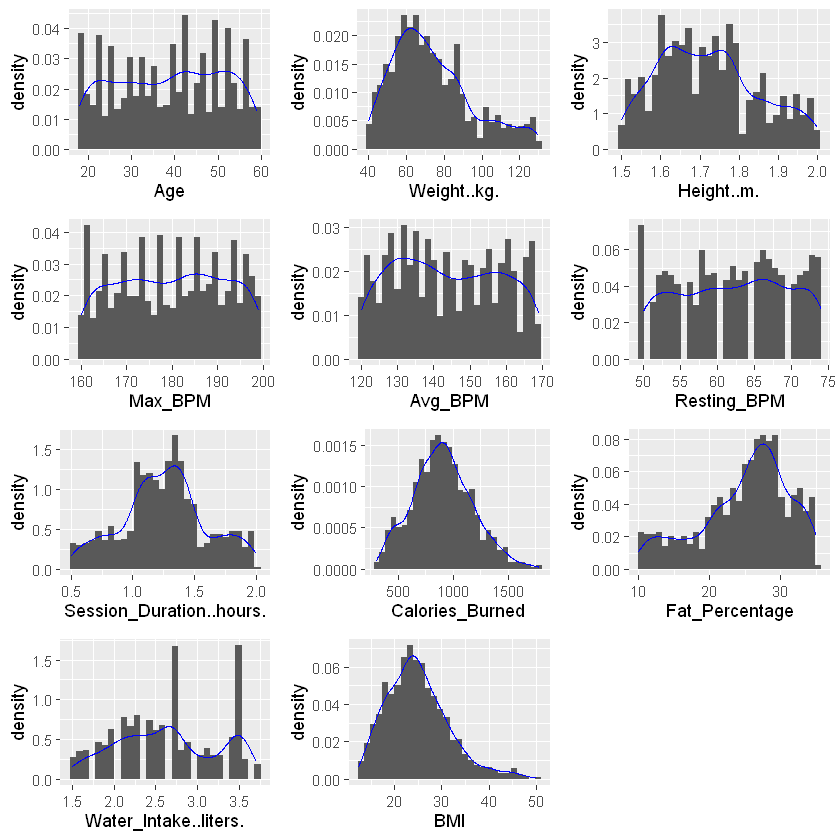

In [10]:
g1<-ggplot(data,aes(x=Age))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
#g2<-ggplot(data,aes(x=Gender))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g3<-ggplot(data,aes(x=Weight..kg.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g4<-ggplot(data,aes(x=Height..m.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g5<-ggplot(data,aes(x=Max_BPM))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g6<-ggplot(data,aes(x=Avg_BPM))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g7<-ggplot(data,aes(x=Resting_BPM))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g8<-ggplot(data,aes(x=Session_Duration..hours.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g9<-ggplot(data,aes(x=Calories_Burned))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
#g10<-ggplot(data,aes(x=Workout_Type))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g11<-ggplot(data,aes(x=Fat_Percentage))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g12<-ggplot(data,aes(x=Water_Intake..liters.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
#g13<-ggplot(data,aes(x=Workout_Frequency..days.week))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
#g14<-ggplot(data,aes(x=Experience_Level))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g15<-ggplot(data,aes(x=BMI))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 

grid.arrange(g1,g3,g4,g5,g6,g7,g8,g9,g11,g12,g15,ncol=3)
rm(g1,g3,g4,g5,g6,g7,g8,g9,g11,g12,g15)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


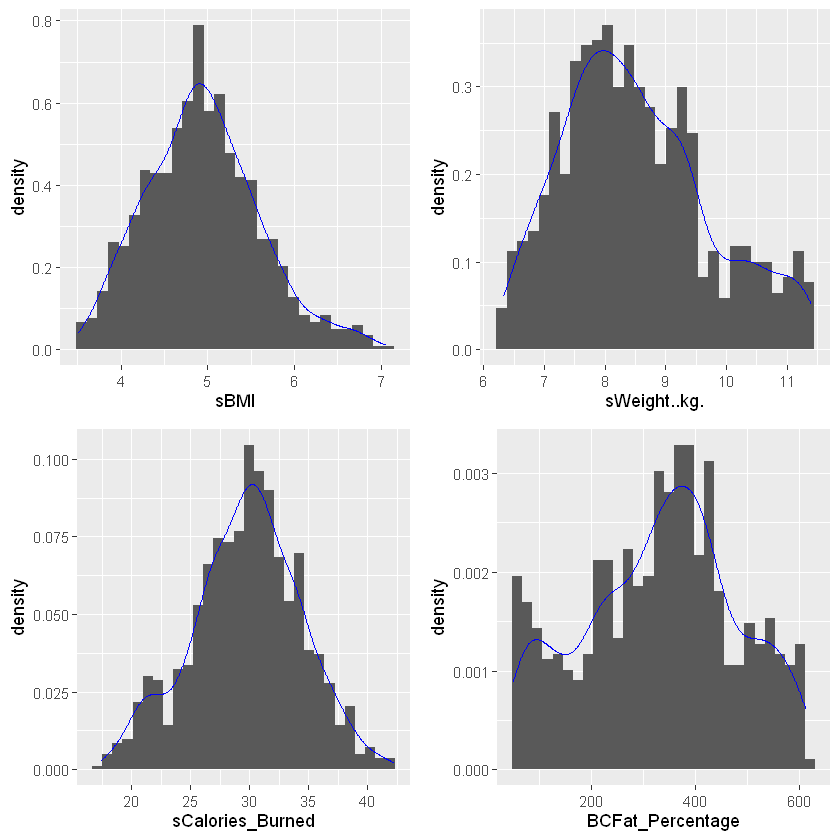

In [11]:
data[, "sBMI"] <- sqrt(data[, "BMI"])
data[, "sWeight..kg."] <- sqrt(data[, "Weight..kg."])
data[, "sCalories_Burned"] <- sqrt(data[, "Calories_Burned"])
lambda = 2
data[, "BCFat_Percentage"] <- (data[, "Fat_Percentage"]**lambda)/lambda
#data[, "sHeight..m."] <- log(data[, "Height..m."])

g16<-ggplot(data,aes(x=sBMI))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g17<-ggplot(data,aes(x=sWeight..kg.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
g18<-ggplot(data,aes(x=sCalories_Burned))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 
g19<-ggplot(data,aes(x=BCFat_Percentage))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue")
#g20<-ggplot(data,aes(x=sHeight..m.))+geom_histogram(aes(y=..density..))+geom_density(alpha=.2, col="blue") 

grid.arrange(g16,g17,g18,g19,ncol=2)
rm(g16,g17,g18,g19)

In [12]:
data <- data[, c(1:2, 4:8, 10, 12:14, 16:19)]

In [13]:
head(data)

,Age,Gender,Height..m.,Max_BPM,Avg_BPM,Resting_BPM,Session_Duration..hours.,Workout_Type,Water_Intake..liters.,Workout_Frequency..days.week.,Experience_Level,sBMI,sWeight..kg.,sCalories_Burned,BCFat_Percentage
,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,56,Male,1.71,180,157,60,1.69,Yoga,3.5,4,3,5.495453,9.396808,36.23534,79.380
2,46,Female,1.53,179,151,66,1.30,HIIT,2.1,4,2,5.656854,8.654479,29.71532,574.605
3,32,Female,1.66,167,122,54,1.11,Cardio,2.3,4,2,4.970915,8.252272,26.01922,557.780
4,25,Male,1.70,190,164,56,0.59,Strength,2.1,3,1,4.290688,7.293833,23.06513,414.720
5,38,Male,1.79,188,158,68,0.64,Strength,2.8,3,1,3.793415,6.789698,23.57965,426.320
6,56,Female,1.68,168,156,74,1.59,HIIT,2.7,5,3,4.533211,7.615773,33.40659,120.125


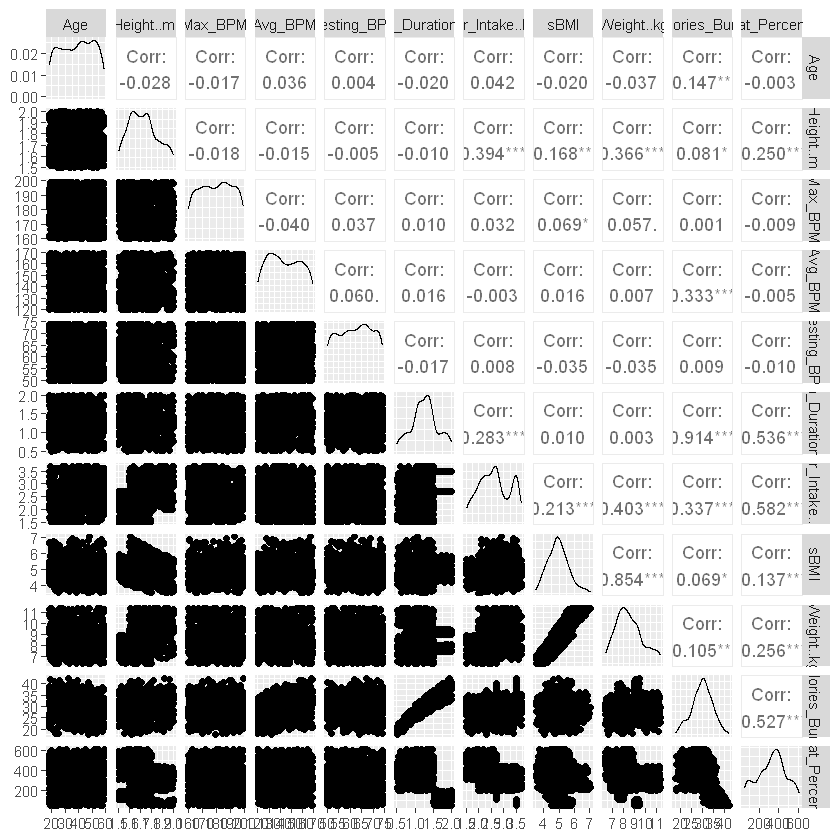

In [26]:
ggpairs(data[, c(1, 3:7, 9 ,12:15)])

In [18]:
install.packages("corrplot")
library(corrplot)

Installation du package dans 'C:/Users/Thomas/AppData/Local/R/win-library/4.4'
(car 'lib' n'est pas spécifié)



le package 'corrplot' a été décompressé et les sommes MD5 ont été vérifiées avec succés

Les packages binaires téléchargés sont dans
	C:\Users\Thomas\AppData\Local\Temp\Rtmps3ysW0\downloaded_packages


Warning message:
"le package 'corrplot' a été compilé avec la version R 4.4.3"
corrplot 0.95 loaded



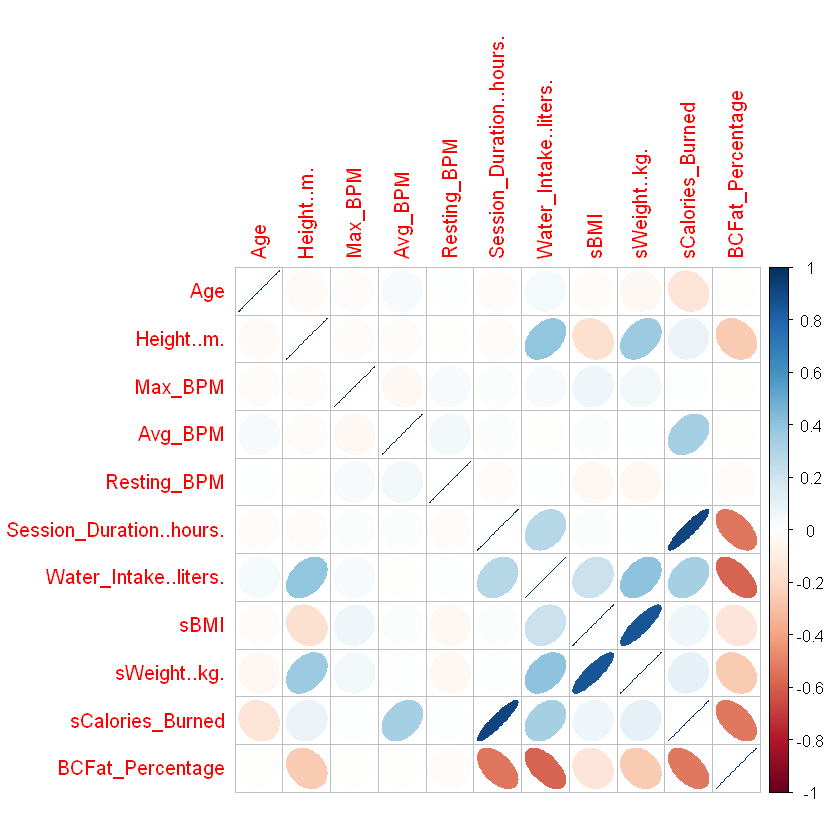

In [27]:
corrplot(cor(data[, c(1, 3:7, 9 ,12:15)]),method="ellipse")